In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [9]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [10]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [11]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect=True)

In [12]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# For example
print(calc_temps('2017-08-01', '2017-08-07'))

[(72.0, 79.25, 83.0)]


In [21]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax for a year in the data set
aug_trip = calc_temps('2017-08-01', '2017-08-07')
aug_trip_df = pd.DataFrame(aug_trip, columns=['tmin', 'tavg', 'tmax'])
aug_trip_df

,tmin,tavg,tmax
0,72.0,79.25,83.0


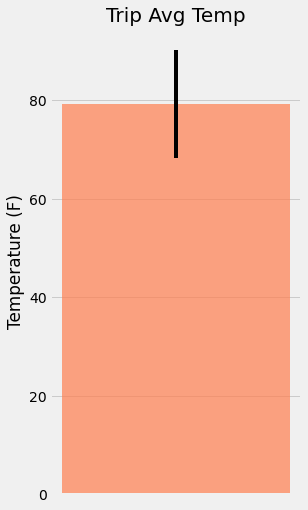

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.0))
xvalue = 1
yvalue= aug_trip_df["tavg"]
yerr = aug_trip_df["tmax"]-aug_trip_df["tmin"]

bar = ax.bar(xvalue, yvalue, alpha=0.7, color='coral', yerr=yerr)
ax.set(xticks=range(xvalue), xticklabels="a")
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temperature (F)")

# Save image
plt.savefig("Images/trip_avg_temp.png")

# Show figure
plt.show()

### Daily Rainfall Average

In [43]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
Results = Session.query(measurement.station, func.sum(measurement.prcp))\
                       .filter(measurement.date>=start_date).filter(measurement.date<=end_date)\
                       .group_by(measurement.station).order_by(func.sum(measurement.prcp).desc()).all()  
print("Station Id\tTotal Rainfall")
for each in Results: print(each[0],"\t",each[1])

AttributeError: Neither 'InstrumentedAttribute' object nor 'Comparator' object associated with measurement.station has an attribute '_query_cls'

In [30]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()

# For example
daily_normals("08-01")

[(67.0, 75.54, 83.0)]

In [31]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Use the start and end date to create a range of dates
trip = pd.date_range(start_date, end_date)

# Strip off the year and save a list of strings in the format %m-%d
trip_dates = trip.strftime("%m-%d")

# Loop through the list and calculate the normals for each date
normals = []
for date in trip_dates:
    normals.append(*daily_normals(date))
list(normals)

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [32]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normals, columns=["tmin", "tavg", "tmax"])
trip_df["Date"] = trip_dates
trip_df.set_index(["Date"], inplace=True)
trip_df

,tmin,tavg,tmax
Date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


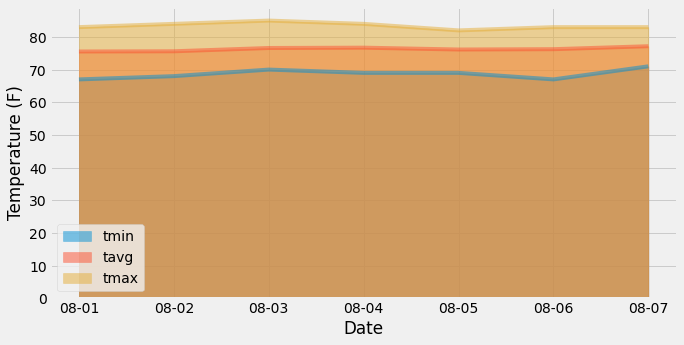

In [40]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot(kind="area", stacked=False, x_compat=True, figsize=(10,5), alpha=0.5)
plt.ylabel("Temperature (F)")

# Save image
plt.savefig("Images/daily_normals.png")

# Show chart
plt.show()

## Close Session

In [41]:
# Close Session
session.close()